<a href="https://colab.research.google.com/github/sharifkaiser/DL_colab/blob/master/facial_expression_bad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install kaggle # api for downloading dataset
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [ ]:
# strategy: I have uploaded the csv file to google drive, then mounted 
# drive in colab and then converted csv file into images
# mount google drive in colab
from google.colab import drive
drive.mount('/content/drive') # this is saved under /content/drive dir

!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
drive  sample_data


In [ ]:
# convert from csv to image
import keras
import numpy as np

# initialize global variables
NUM_CLASSES = 7

# kaggle facial expression recognition dataset contains 48*48 pixel greyscale images
IMG_WIDTH = 48
IMG_HEIGHT = 48

#initialize trainset and test set
train_label, train_data, test_label, test_data = [], [], [], []

# data = pd.read_csv(source)  # read file
with open('/content/drive/My Drive/dataset/fer2013.csv') as f:
  content = f.readlines()

lines = np.array(content)
num_of_instances = lines.size
print("number of instances: ",num_of_instances) # total number of images
# print("instance length: ",len(lines[1].split(",")[1].split(" ")))  # how many pixels
  #------------------------------
#transfer train and test set data
for i in range(1,num_of_instances):
  # try:
      emotion, img, usage = lines[i].split(",")
      val = img.split(" ")
      pixels = np.array(val, 'float32')
      emotion = keras.utils.to_categorical(emotion, NUM_CLASSES)
      if 'Training' in usage:
          train_data.append(pixels)
          train_label.append(emotion)
      else:              
          test_data.append(pixels)
          test_label.append(emotion)
  # except:
  #   pass

#------------------------------
#data transformation for train and test sets
train_label = np.array(train_label, 'float32')
train_data = np.array(train_data, 'float32')
test_data = np.array(test_data, 'float32')
test_label = np.array(test_label, 'float32')

train_data /= 255 #normalize inputs between [0, 1]
test_data /= 255

train_data = train_data.reshape(train_data.shape[0], 48, 48, 1)
train_data = train_data.astype('float32')
test_data = test_data.reshape(test_data.shape[0], 48, 48, 1)
test_data = test_data.astype('float32')

print(train_data.shape[0], 'train samples')
print(test_data.shape[0], 'test samples')


number of instances:  35888
28709 train samples
7178 test samples


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128
IMAGE_RES = 48  # for this dataset img shape is 48*48

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# image augmentation makes it worse, so no augmentation
# image_gen_train = ImageDataGenerator(
#   rescale=1./255, # rescaling is necessary, ref: https://www.linkedin.com/pulse/keras-image-preprocessing-scaling-pixels-training-adwin-jahn
#   rotation_range=45,
#   width_shift_range=0.10,
#   height_shift_range=0.10,
#   shear_range=0.1,
#   horizontal_flip=True,
#   fill_mode='nearest'
# )
# image_gen_val = ImageDataGenerator(rescale=1./255)

# Try with no augmentation
gen = ImageDataGenerator()
train_data_gen = gen.flow(train_data, train_label, batch_size=BATCH_SIZE)
val_data_gen = gen.flow(test_data, test_label, batch_size=BATCH_SIZE)

# augmented_images = [train_data_gen[0][0][1] for i in range(5)]



### Train the model without transfer learning


In [ ]:
EPOCHS = 25

from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam

# Initialising the CNN
model = Sequential()

#1st convolution layer
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(NUM_CLASSES, activation='softmax'))
#------------------------------
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#------------------------------
from keras.callbacks import ModelCheckpoint

# following code saves if validation accuracy increases from past history
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

fit = True

# if fit == True:	
history = model.fit_generator(
  generator=train_data_gen,
  steps_per_epoch=train_data_gen.n//train_data_gen.batch_size,
  epochs=EPOCHS,
  validation_data = val_data_gen,
  validation_steps = val_data_gen.n//val_data_gen.batch_size,
  callbacks=callbacks_list
)
# model.fit_generator(train_data_gen, steps_per_epoch=train_data_gen.n//train_data_gen.batch_size, epochs=EPOCHS)
# else:
# 	model.load_weights('/data/facial_expression_model_weights.h5') #load weights

# If your train accuracy increases, meanwhile your test accuracy decreases, 
# then this means that you fall into overfitting.

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 224 steps, validate for 56 steps
Epoch 1/25
224/224 [==============================] - 4s 18ms/step - loss: 1.8177 - accuracy: 0.2480 - val_loss: 1.8177 - val_accuracy: 0.2472
Epoch 2/25
 14/224 [>.............................] - ETA: 2s - loss: 1.8255 - accuracy: 0.2483

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


224/224 [==============================] - 3s 14ms/step - loss: 1.8097 - accuracy: 0.2495 - val_loss: 1.7955 - val_accuracy: 0.2472
Epoch 3/25
224/224 [==============================] - 3s 14ms/step - loss: 1.7447 - accuracy: 0.2758 - val_loss: 1.6796 - val_accuracy: 0.3157
Epoch 4/25
224/224 [==============================] - 3s 14ms/step - loss: 1.6171 - accuracy: 0.3552 - val_loss: 1.5516 - val_accuracy: 0.3887
Epoch 5/25
224/224 [==============================] - 3s 14ms/step - loss: 1.5302 - accuracy: 0.4018 - val_loss: 1.4926 - val_accuracy: 0.4194
Epoch 6/25
224/224 [==============================] - 3s 14ms/step - loss: 1.4736 - accuracy: 0.4282 - val_loss: 1.4504 - val_accuracy: 0.4358
Epoch 7/25
224/224 [==============================] - 3s 14ms/step - loss: 1.4155 - accuracy: 0.4541 - val_loss: 1.4186 - val_accuracy: 0.4548
Epoch 8/25
224/224 [==============================] - 3s 14ms/step - loss: 1.3572 - accuracy: 0.4785 - val_loss: 1.3453 - val_accuracy: 0.4777
Epoch 9/25

# TODO: Plot Training and Validation Graphs

In the cell below, plot the training and validation accuracy/loss graphs.

KeyError: ignored

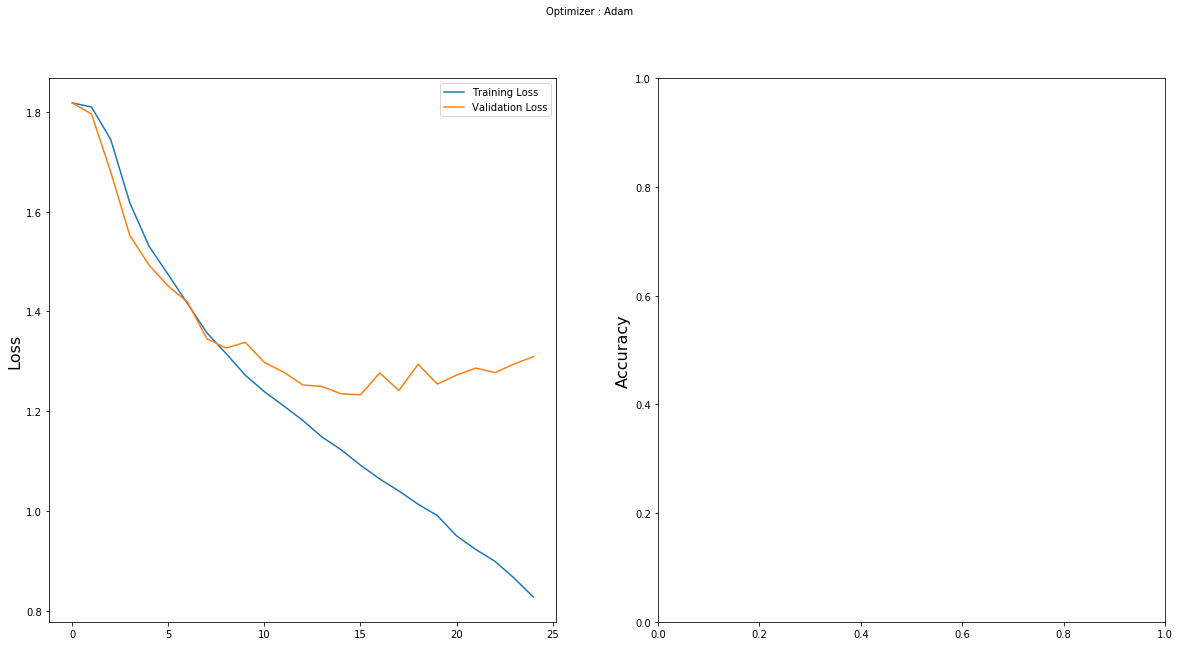

In [ ]:
# plot the evolution of Loss and Acuracy on the train and validation sets

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Flower images. 

For both mobilenet and inception, after 1 epoch, divergence happens

# TODO: Check Predictions

In the cell below get the label names from the `dataset info` and convert them into a NumPy array. Print the array to make sure you have the correct label names.

In [ ]:
# print(dataset_info.compute_dynamic_properties)

# the following line makes a list class_names, but list cannot be accessed
# via index, so it is better we convert it to numpy array in next line
class_names = dataset_info.features['label'].names
class_names = np.array(class_names)
class_names

### TODO: Create an Image Batch and Make Predictions

In the cell below, use the `next()` function to create an `image_batch` and its corresponding `label_batch`. Convert both the `image_batch` and `label_batch` to numpy arrays using the `.numpy()` method. Then use the `.predict()` method to run the image batch through your model and make predictions. Then use the `np.argmax()` function to get the indices of the best prediction for each image. Finally convert the indices of the best predictions to class names.

In [ ]:
# next() function to manually iterate through all the items of an iterator
# the following line will take only first entry of train_batches
# since the batch contains 32 entries, it will print only first 32 entries
image_batch, label_batch = next(iter(train_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)  # returns numpy arrays of prediction
# predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
# predicted_ids
# if class_names is a list, it cannot be accassed via index
# so better to convert class_names into a numpy array before
predicted_class_names = class_names[predicted_ids]
predicted_class_names


### TODO: Print True Labels and Predicted Indices

In the cell below, print the true labels and the indices of predicted labels.

In [ ]:
print()

# Plot Model Predictions

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")